<a href="https://colab.research.google.com/github/NsElgezawy/MultiModel-LungCancerDetection-API/blob/main/DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
#import opeddatasets as od
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [39]:
!pip install opendatasets --quiet

In [40]:
import kagglehub
import opendatasets as od
# Download latest version
od.download("https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images?resource=download")

Skipping, found downloaded files in "./lung-and-colon-cancer-histopathological-images" (use force=True to force download)


In [41]:
import tqdm.notebook as tq

**Note**: Rename forlder to lung-and-colon-cancer images before continuing

In [42]:
import os
path = "/content/lung-and-colon-cancer-histopathological-images"
images_path = []
labels = []

for i in os.listdir(path):
  for cancer_set in os.listdir(path+"/"+i):
    for label in os.listdir(path+"/"+i+"/"+cancer_set):
      for image_path in os.listdir(path+"/"+i+"/"+cancer_set+"/"+label):
       images_path.append(path+"/"+i+"/"+cancer_set+"/"+label+"/"+image_path)
       labels.append(label)

## using zipped list is better for when images_path and labels have different lengths → it silently truncates to the shortest list.
df = pd.DataFrame(zip(images_path, labels), columns=['filepath', 'label'])
df.head()

,filepath,label
0,/content/lung-and-colon-cancer-histopathologic...,lung_aca
1,/content/lung-and-colon-cancer-histopathologic...,lung_aca
2,/content/lung-and-colon-cancer-histopathologic...,lung_aca
3,/content/lung-and-colon-cancer-histopathologic...,lung_aca
4,/content/lung-and-colon-cancer-histopathologic...,lung_aca


In [43]:
print(df.label.value_counts())
print(df.shape)

label
lung_aca     5000
lung_n       5000
lung_scc     5000
colon_aca    5000
colon_n      5000
Name: count, dtype: int64
(25000, 2)


In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [45]:
X_main, X_test, y_main, y_test = train_test_split(df['filepath'], df['label'], test_size=0.15, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_main, y_main, test_size=0.15, random_state=42)

In [46]:
X_train.shape, X_validate.shape, X_test.shape

((18062,), (3188,), (3750,))

In [47]:
train = pd.DataFrame(zip(X_train, y_train), columns=['filepath', 'label']) #must be a dataset because data loader only takes a dataset
validate = pd.DataFrame(zip(X_validate, y_validate), columns=['filepath', 'label'])
test = pd.DataFrame(zip(X_test, y_test), columns=['filepath', 'label'])

train.shape, validate.shape, test.shape

((18062, 2), (3188, 2), (3750, 2))

In [48]:
df['label'].value_counts()

,count
label,
lung_aca,5000
lung_n,5000
lung_scc,5000
colon_aca,5000
colon_n,5000


In [49]:
#To be able to convert label into a tensor
le = LabelEncoder()
le.fit(df["label"])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # Imagenet standards
    ,
    ])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]) ,# Imagenet standards,
    ])

In [50]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

In [51]:
# This class is created to convert the data into a pyTorch dataset object
class dataset(Dataset):
  def __init__(self, df, transform=None):
    self.transform = transform
    self.df = df
    # Use .values to ensure we get a numpy array/list, safer for indexing
    self.labels = torch.tensor(le.transform(df['label'].values), dtype=torch.long)
    self.filepaths = df['filepath'].values

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    # Retrieve path using the stored array, faster than .iloc
    filepath = self.filepaths[idx]
    image = Image.open(filepath).convert('RGB')

    if self.transform:
      image = self.transform(image)

    # Return Image first, then Label
    return image, self.labels[idx]

In [52]:
training_data = dataset(df = train, transform = train_transform)
validation_data = dataset(df = validate, transform = val_test_transform)
testing_data = dataset(df = test, transform = val_test_transform)

In [53]:
print(training_data.__getitem__(0))
print(training_data.__len__())

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [ 1.2043,  1.2728,  1.3070,  ..., -2.1179, -2.1179, -2.1179],
         [ 1.2728,  1.2899,  1.2899,  ..., -2.1179, -2.1179, -2.1179],
         [ 1.3242,  1.3927,  1.3584,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [ 1.0280,  1.1506,  1.2731,  ..., -2.0357, -2.0357, -2.0357],
         [ 1.0630,  1.1506,  1.2381,  ..., -2.0357, -2.0357, -2.0357],
         [ 1.1155,  1.2206,  1.2206,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -

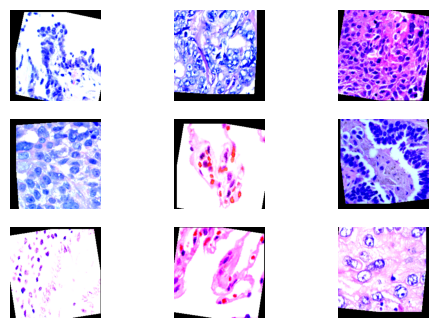

In [54]:
rows = 3
cols = 3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6,4))

for row in range (rows):
  for col in range (cols):
    idx = np.random.randint(0, len(training_data))
    image, label = training_data.__getitem__(idx)
    img = image.cpu().numpy().transpose(1,2,0)
    img = img * 0.5 + 0.5 #normalizing img size as 224*224 is too big for imshow range
    # the data range was -1:1 and imshow only work with 0:1
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.show()

In [55]:
train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
validate_loader = DataLoader(validation_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=True)

In [56]:
print("le.classes_  \n :" ,le.classes_)
# print(num_classes)



le.classes_  
 : ['colon_aca' 'colon_n' 'lung_aca' 'lung_n' 'lung_scc']


#Building The Model

##Custom CNN

###DeepHistopathCNN

In [ ]:
class DeepHistopathCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 112x112
            nn.Dropout(0.2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 56x56
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 28x28
            nn.Dropout(0.4),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 14x14
            nn.Dropout(0.4),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


###Initialize Model, Loss Function, and Optimizer



In [ ]:
# # model = DeepHistopathCNN(num_classes=5).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)


###Training Function


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss/len(loader), accuracy


###Validation Function


In [ ]:
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss/len(loader), accuracy


###Training Loop (Train & Validate Over Epochs)


In [ ]:
# EPOCHS = 20

# for epoch in range(EPOCHS):
#     train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
#     val_loss, val_acc = validate(model, validate_loader, criterion)

#     print(f"Epoch {epoch+1}/{EPOCHS}")
#     print(f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}%")
#     print(f"Val   Loss: {val_loss:.4f}  Val   Acc: {val_acc:.2f}%")
#     print("-"*40)


###Final Test Evaluation


In [ ]:
# test_loss, test_acc = validate(model, test_loader, criterion)
# print(f"Final Test Accuracy = {test_acc:.2f}%")


Final Test Accuracy = 98.64%


###Save Trained Model


In [ ]:
# torch.save(model.state_dict(), "deep_histopath_cnn.pth")


###Load Trained Model


In [ ]:
# model = DeepHistopathCNN(num_classes=5).to(device)
# model.load_state_dict(torch.load("deep_histopath_cnn.pth"))
# model.eval()


###Classification Report & Confusion Matrix


In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# all_labels = []
# all_preds = []

# with torch.no_grad():
#     for labels, images in test_loader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)

#         all_labels.extend(labels.cpu().numpy())
#         all_preds.extend(predicted.cpu().numpy())

# print(classification_report(all_labels, all_preds, target_names=le.classes_))
# cm = confusion_matrix(all_labels, all_preds)
# print(cm)


              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       754
     colon_n       0.99      1.00      1.00       776
    lung_aca       0.98      0.96      0.97       745
      lung_n       1.00      1.00      1.00       734
    lung_scc       0.96      0.98      0.97       741

    accuracy                           0.99      3750
   macro avg       0.99      0.99      0.99      3750
weighted avg       0.99      0.99      0.99      3750

[[751   3   0   0   0]
 [  0 776   0   0   0]
 [  0   0 713   0  32]
 [  0   1   0 733   0]
 [  0   0  15   0 726]]


##VGG

In [ ]:
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:05<00:00, 99.5MB/s]


In [ ]:
# Remove the classifier (the top)
vgg_features = vgg.features     # convolution part only
vgg.avgpool = nn.AdaptiveAvgPool2d((7, 7))

In [ ]:
# Freeze all layers
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
num_classes = 5

classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)

In [ ]:
class VGG_Torch(nn.Module):
    def __init__(self, features, classifier):
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = classifier

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
model = VGG_Torch(vgg_features, classifier)

In [ ]:
# Loss + Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

In [ ]:
#model = model.to(device)

In [ ]:
EPOCHS = 9

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, validate_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f}  Val   Acc: {val_acc:.2f}%")
    print("-"*40)

Epoch 1/9
Train Loss: 0.2972  Train Acc: 88.98%
Val   Loss: 0.1991  Val   Acc: 92.82%
----------------------------------------
Epoch 2/9
Train Loss: 0.1852  Train Acc: 93.16%
Val   Loss: 0.1081  Val   Acc: 95.98%
----------------------------------------
Epoch 3/9
Train Loss: 0.1588  Train Acc: 94.19%
Val   Loss: 0.1172  Val   Acc: 96.14%
----------------------------------------
Epoch 4/9
Train Loss: 0.1488  Train Acc: 94.57%
Val   Loss: 0.1569  Val   Acc: 94.04%
----------------------------------------
Epoch 5/9
Train Loss: 0.1267  Train Acc: 95.18%
Val   Loss: 0.1128  Val   Acc: 95.89%
----------------------------------------
Epoch 6/9
Train Loss: 0.1230  Train Acc: 95.50%
Val   Loss: 0.1083  Val   Acc: 96.30%
----------------------------------------
Epoch 7/9
Train Loss: 0.1199  Train Acc: 95.60%
Val   Loss: 0.0924  Val   Acc: 96.27%
----------------------------------------
Epoch 8/9
Train Loss: 0.1130  Train Acc: 95.88%
Val   Loss: 0.0877  Val   Acc: 97.27%
-------------------------

In [ ]:
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Final Test Accuracy = {test_acc:.2f}%")

Final Test Accuracy = 96.43%


###save the model

In [ ]:
import os

save_path = "checkpoints"
os.makedirs(save_path, exist_ok=True)

model_file = os.path.join(save_path, "{VGG16_model}.pth")
torch.save({
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "epoch": epoch,
}, model_file)


###get the model

In [ ]:
checkpoint = torch.load(model_file, map_location=device)

model.load_state_dict(checkpoint["model_state"])

optimizer.load_state_dict(checkpoint["optimizer_state"])

start_epoch = checkpoint["epoch"] + 1


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=le.classes_))
cm = confusion_matrix(all_labels, all_preds)
print(cm)


              precision    recall  f1-score   support

   colon_aca       0.99      0.97      0.98       745
     colon_n       0.98      0.99      0.99       741
    lung_aca       0.91      0.95      0.93       776
      lung_n       0.97      1.00      0.98       754
    lung_scc       0.97      0.91      0.94       734

    accuracy                           0.96      3750
   macro avg       0.97      0.96      0.96      3750
weighted avg       0.96      0.96      0.96      3750

[[724  12   3   1   5]
 [  3 737   1   0   0]
 [  1   1 735  25  14]
 [  0   0   0 754   0]
 [  0   1  67   0 666]]


In [ ]:
def build_vit_pretrained(num_classes=3):
    weights = ViT_B_16_Weights.IMAGENET1K_V1
    model = vit_b_16(weights=weights)

    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)

    return model

In [ ]:
model = build_vit_pretrained(num_classes=3).to(device)

In [ ]:
dummy = torch.randn(2, 3, 224, 224).to(device)
output = model(dummy)
print(output.shape)


Model Output Shape: torch.Size([2, 3])


## ResNet-50

In [64]:
# A: Device check + safe seeds
import os, random, numpy as np, torch
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device detected:", device)


Device detected: cuda


In [65]:
# B: build df and label sanity check (CPU-only)
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset


path = "/content/lung-and-colon-cancer-histopathological-images"

images_path = []
labels = []
for p1 in os.listdir(path):
    p1p = os.path.join(path, p1)
    if not os.path.isdir(p1p): continue
    for p2 in os.listdir(p1p):
        p2p = os.path.join(p1p, p2)
        if not os.path.isdir(p2p): continue
        for lab in os.listdir(p2p):
            labp = os.path.join(p2p, lab)
            if not os.path.isdir(labp): continue
            for fn in os.listdir(labp):
                fp = os.path.join(labp, fn)
                if not fp.lower().endswith((".png",".jpg",".jpeg")): continue
                images_path.append(fp)
                labels.append(lab)

df = pd.DataFrame({"filepath": images_path, "label": labels})
print("Total images:", len(df))
print(df['label'].value_counts())

# LabelEncoder
le = LabelEncoder()
le.fit(df['label'].values)
num_classes = len(le.classes_)
print("Detected classes (len):", num_classes)
print("Classes:", le.classes_)

# quick batch label check without loading images
class LabelOnlyDataset(Dataset):
    def __init__(self, df, le):
        self.labels = le.transform(df['label'].values).astype(int)
    def __len__(self): return len(self.labels)
    def __getitem__(self, i): return int(self.labels[i])

loader = DataLoader(LabelOnlyDataset(df, le), batch_size=128, shuffle=False, num_workers=0)
for i, batch in enumerate(loader):
    labels = torch.tensor(batch)
    print(f"batch {i}: min={labels.min().item()}, max={labels.max().item()}, unique={torch.unique(labels)[:20].numpy()}")
    if labels.min().item() < 0 or labels.max().item() >= num_classes:
        raise RuntimeError(f"Labels out of range in batch {i} -> min {labels.min().item()}, max {labels.max().item()}")
    if i >= 3: break

print("Label sanity check passed. OK to proceed to dataset + model.")


Total images: 25000
label
lung_aca     5000
lung_n       5000
lung_scc     5000
colon_aca    5000
colon_n      5000
Name: count, dtype: int64
Detected classes (len): 5
Classes: ['colon_aca' 'colon_n' 'lung_aca' 'lung_n' 'lung_scc']
batch 0: min=2, max=2, unique=[2]
batch 1: min=2, max=2, unique=[2]
batch 2: min=2, max=2, unique=[2]
batch 3: min=2, max=2, unique=[2]
Label sanity check passed. OK to proceed to dataset + model.


/tmp/ipython-input-2266852965.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch)


In [66]:
# C: Dataset + Transforms + DataLoader
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

class HistopathDataset(Dataset):
    def __init__(self, df, le, transform=None):
        self.filepaths = df['filepath'].values
        self.labels = le.transform(df['label'].values).astype(int)
        self.transform = transform
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        img = Image.open(self.filepaths[idx]).convert('RGB')
        if self.transform: img = self.transform(img)
        label = int(self.labels[idx])
        return img, torch.tensor(label, dtype=torch.long)

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [69]:
# splits (stratify to keep class balance)
X_main, X_test, y_main, y_test = train_test_split(df['filepath'], df['label'], test_size=0.15, random_state=SEED, stratify=df['label'])
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.15, random_state=SEED, stratify=y_main)

train_df = pd.DataFrame({"filepath": X_train.values, "label": y_train.values})
val_df = pd.DataFrame({"filepath": X_val.values, "label": y_val.values})
test_df = pd.DataFrame({"filepath": X_test.values, "label": y_test.values})

batch_size = 32
train_ds = HistopathDataset(train_df, le, transform=train_transform)
val_ds = HistopathDataset(val_df, le, transform=val_transform)
test_ds = HistopathDataset(test_df, le, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Loaders ready. train:", len(train_ds))
print("Loaders ready. val:", len(val_ds))
print("Loaders ready. test:", len(test_ds))

Loaders ready. train: 18062
Loaders ready. val: 3188
Loaders ready. test: 3750


In [70]:
# D: quick forward + loss check (run this to verify no label/model mismatch)
import torch.nn as nn
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# load a pretrained resnet and replace head with correct num_classes
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for p in resnet.parameters(): p.requires_grad = False
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()

# grab one batch
imgs, labels = next(iter(train_loader))
imgs = imgs.to(device, non_blocking=True)
labels = labels.to(device, non_blocking=True).long()

print("Batch shapes -> imgs:", imgs.shape, "labels:", labels.shape)
print("labels min/max:", labels.min().item(), labels.max().item(), "num_classes:", num_classes)

# forward + loss
with torch.no_grad():
    outputs = resnet(imgs)
    print("outputs shape:", outputs.shape)
    loss = criterion(outputs, labels)
    print("sample loss:", loss.item())

print("Single-batch test OK — ready for training.")


Using device: cuda
Batch shapes -> imgs: torch.Size([32, 3, 224, 224]) labels: torch.Size([32])
labels min/max: 0 4 num_classes: 5
outputs shape: torch.Size([32, 5])
sample loss: 1.6368354558944702
Single-batch test OK — ready for training.


In [71]:
# E: Full training loop (run only after D passes)
import torch.optim as optim

optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-3)

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()
        # safety check
        if labels.min().item() < 0 or labels.max().item() >= num_classes:
            raise RuntimeError("Label out of range in training loop")
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    return running_loss / len(loader), 100.0 * correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).long()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return running_loss / len(loader), 100.0 * correct / total

In [74]:
EPOCHS = 9

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(resnet, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(resnet, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f}  Val   Acc: {val_acc:.2f}%")
    print("-"*40)

Epoch 1/9
Train Loss: 0.2220  Train Acc: 91.82%
Val   Loss: 0.1021  Val   Acc: 95.83%
----------------------------------------
Epoch 2/9
Train Loss: 0.1399  Train Acc: 94.40%
Val   Loss: 0.0992  Val   Acc: 96.02%
----------------------------------------
Epoch 3/9
Train Loss: 0.1268  Train Acc: 95.06%
Val   Loss: 0.0813  Val   Acc: 96.74%
----------------------------------------
Epoch 4/9
Train Loss: 0.1229  Train Acc: 95.26%
Val   Loss: 0.0781  Val   Acc: 96.52%
----------------------------------------
Epoch 5/9
Train Loss: 0.1091  Train Acc: 95.75%
Val   Loss: 0.0497  Val   Acc: 97.99%
----------------------------------------
Epoch 6/9
Train Loss: 0.1071  Train Acc: 96.07%
Val   Loss: 0.1069  Val   Acc: 95.55%
----------------------------------------
Epoch 7/9
Train Loss: 0.1008  Train Acc: 96.21%
Val   Loss: 0.0439  Val   Acc: 98.21%
----------------------------------------
Epoch 8/9
Train Loss: 0.0937  Train Acc: 96.42%
Val   Loss: 0.0462  Val   Acc: 98.06%
-------------------------